In [1]:
import os
seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import pickle

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02/experiment_set_8'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
def load_dataset(filename, load_test_set=True):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        if load_test_set:
            W_test = np.array(hdf.get('W_test'))           # W
            X_s_test = np.array(hdf.get('X_s_test'))       # X_s
            X_v_test = np.array(hdf.get('X_v_test'))       # X_v
            T_test = np.array(hdf.get('T_test'))           # T
            Y_test = np.array(hdf.get('Y_test'))           # RUL  
            A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Column names
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns.append(list(np.array(A_var, dtype='U20')))
        columns.append(list(np.array(T_var, dtype='U20')))
        columns.append(list(np.array(X_s_var, dtype='U20')))
        columns.append(list(np.array(X_v_var, dtype='U20')))
        columns.append(list(np.array(W_var, dtype='U20')))
        columns.append(['RUL'])
        
        columns_list = []
        for columns_per_category in columns:
            columns_list += columns_per_category
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    if load_test_set:
        test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
        return pd.DataFrame(data=train_set, columns=columns_list), pd.DataFrame(data=test_set, columns=columns_list), columns
    else:
        return pd.DataFrame(data=train_set, columns=columns_list), None, columns

In [8]:
start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename, load_test_set=True)
print("Operation time (sec): " , (time.process_time() - start_time))
print("Train set shape: " + str(train_set.shape))
print("Test set shape: " + str(test_set.shape))

Operation time (sec):  4.640625
Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [9]:
columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 

columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

In [10]:
def unit_cycle_info(df, compute_cycle_len=False):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        num_entries = len(df.loc[df['unit'] == i])
        print('Unit: ', i, ' - Num flight cycles: ', num_cycles, ' - Num entries: ', num_entries)
        
    if compute_cycle_len:
        cycle_ids = np.unique(df['cycle'])
        print('Total number of cycles: ', len(cycle_ids))
        min_len = np.inf
        max_len = 0
        for i in cycle_ids:
            cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
            if cycle_len < min_len:
                min_len = cycle_len
            elif cycle_len > max_len:
                max_len = cycle_len
        print('Min cycle length: ', min_len)
        print('Max cycle length: ', max_len)
    
    return unit_ids

def failure_modes_info(df):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    
    for i in unit_ids:
        df_unit = df.loc[df['unit'] == i]
        
        constant_filter = VarianceThreshold(threshold=variance_th)
        constant_filter.fit(dataset)
        constant_features = [col for col in dataset.columns 
                           if col not in dataset.columns[constant_filter.get_support()]]
        

In [11]:
# Filter constant and quasi-constant features
def get_quasi_constant_features(dataset, variance_th=0.01, debug=True):
    constant_filter = VarianceThreshold(threshold=variance_th)
    constant_filter.fit(dataset)
    constant_features = [col for col in dataset.columns 
                         if col not in dataset.columns[constant_filter.get_support()]]
    
    if debug:
        print("Number of non-constant features: ", len(dataset.columns[constant_filter.get_support()]))
        
        print("Number of quasi-constant features: ", len(constant_features))
        print("Quasi-constant features: ")
        for col in constant_features:
            print(col)
    return constant_features

def get_non_correlated_features(dataset, corr_th=0.9, debug=True):
    corr_mat = dataset.corr()
    corr_mat = np.abs(corr_mat)
    
    num_cols = corr_mat.shape[0]
    columns = np.full((num_cols,), True, dtype=bool)
    for i in range(num_cols):
        for j in range(i+1, num_cols):
            if columns[i]:
                val = corr_mat.iloc[i, j]
                if val >= corr_th and columns[j]:
                    columns[j] = False
                    if debug:
                        print(dataset.columns[i], "|", dataset.columns[j], "|", round(val, 2))
    if debug:        
        correlated_features = dataset.columns[~columns]
        print("Number of correlated features: ", len(correlated_features))
        print("Correlated features: ", list(correlated_features))
    
    selected_columns = dataset.columns[columns]
    if debug:
        print("Number of selected features: ", len(selected_columns))
        print("Selected features: ", list(selected_columns))
    return selected_columns

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    corr_matrix = np.abs(corr_matrix)
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [27]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.9, random_state=seed)

In [28]:
auxiliary_columns = ['cycle', 'hs', 'Fc', 'unit']
x_train.drop(labels=[x for x in auxiliary_columns if x in x_train.columns], axis=1, inplace=True)

In [22]:
from sklearn.feature_selection import mutual_info_regression

start_time = time.process_time()  
mi = mutual_info_regression(x_train, y_train, random_state=seed)
print("Operation time (sec): " , (time.process_time() - start_time))

Operation time (sec):  859.984375


In [23]:
mi_series = pd.Series(mi, index=x_train.columns)
mi_series = mi_series.sort_values(ascending=False)

In [24]:
normalized_mi = (mi_series - mi_series.min()) / (mi_series.max() - mi_series.min())

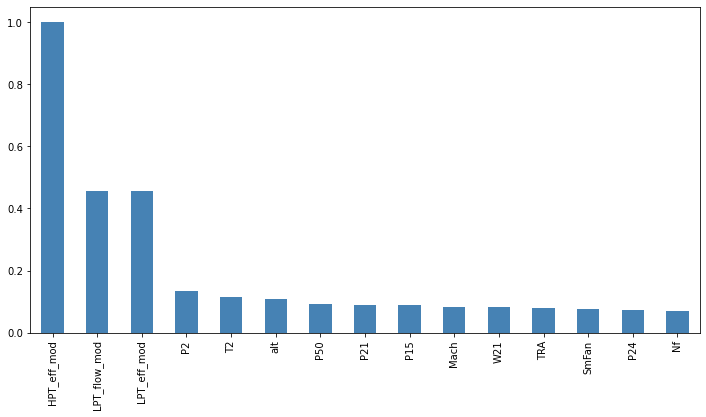

In [26]:
normalized_mi[:15].plot.bar(color='steelblue', figsize=(12, 6))
plt.savefig("mutual_info.png")

In [18]:
x_train.corrwith(y_train).sort_values(ascending=False)

HPT_eff_mod     0.751772
LPT_flow_mod    0.489825
LPT_eff_mod     0.473342
SmLPC           0.215121
SmHPC           0.105208
Nc              0.026882
W25             0.013903
W32             0.013903
W31             0.013903
W22             0.013901
W50             0.013282
W48             0.013246
Mach            0.013179
T30             0.012871
SmFan           0.012770
TRA             0.008674
Nf              0.008351
alt             0.007691
P40             0.005571
P30             0.005571
Ps30            0.004417
W21            -0.001102
P45            -0.003166
P21            -0.003623
P15            -0.003623
T2             -0.004511
P2             -0.004756
P24            -0.005246
P50            -0.005671
T24            -0.007947
Wf             -0.017543
T40            -0.050204
T48            -0.072477
phi            -0.091470
T50            -0.123531
fan_eff_mod          NaN
fan_flow_mod         NaN
LPC_eff_mod          NaN
LPC_flow_mod         NaN
HPC_eff_mod          NaN


In [16]:
initial_columns = x_train.columns
selected_columns_1 = columns_sensor_measurements + columns_virtual_sensors + columns_operating_conditions

x_train.drop(labels=[x for x in initial_columns if x not in selected_columns_1], axis=1, inplace=True)

In [34]:
x_train.shape

(3684412, 35)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

In [35]:
selected_columns = get_non_correlated_features(x_train, corr_th=0.99)

T30 | Nc | 1.0
T48 | T40 | 1.0
P15 | P21 | 1.0
P15 | P50 | 0.99
P2 | alt | 0.99
P2 | T2 | 0.99
P24 | W21 | 1.0
Ps30 | P40 | 1.0
Ps30 | P30 | 1.0
Ps30 | P45 | 1.0
Ps30 | W22 | 0.99
Ps30 | W25 | 0.99
Ps30 | W31 | 0.99
Ps30 | W32 | 0.99
Ps30 | W48 | 0.99
Ps30 | W50 | 0.99
SmHPC | phi | 0.99
Number of correlated features:  17
Correlated features:  ['P21', 'P40', 'P50', 'Nc', 'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'phi', 'alt', 'T2']
Number of selected features:  18
Selected features:  ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P24', 'Ps30', 'Nf', 'Wf', 'SmFan', 'SmLPC', 'SmHPC', 'Mach', 'TRA']


In [36]:
selected_columns = get_non_correlated_features(x_train, corr_th=0.95)

T24 | Ps30 | 0.99
T24 | P40 | 0.99
T24 | Wf | 0.97
T24 | P30 | 0.99
T24 | P45 | 0.98
T24 | W22 | 0.98
T24 | W25 | 0.98
T24 | W31 | 0.98
T24 | W32 | 0.98
T24 | W48 | 0.98
T24 | W50 | 0.98
T30 | T48 | 0.97
T30 | T50 | 0.95
T30 | Nc | 1.0
T30 | T40 | 0.97
P15 | P2 | 0.97
P15 | P21 | 1.0
P15 | P24 | 0.99
P15 | P50 | 0.99
P15 | W21 | 0.99
P15 | alt | 0.96
P15 | T2 | 0.97
Nf | SmHPC | 0.98
Nf | phi | 0.97
Nf | TRA | 0.97
Number of correlated features:  25
Correlated features:  ['T48', 'T50', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nc', 'Wf', 'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmHPC', 'phi', 'alt', 'TRA', 'T2']
Number of selected features:  10
Selected features:  ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'T24', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach']


In [33]:
constant_features = get_quasi_constant_features(x_train, variance_th=0.0)
x_train.drop(labels=constant_features, axis=1, inplace=True)
print("Train shape: ", x_train.shape)

Number of non-constant features:  35
Number of quasi-constant features:  7
Quasi-constant features: 
fan_eff_mod
fan_flow_mod
LPC_eff_mod
LPC_flow_mod
HPC_eff_mod
HPC_flow_mod
HPT_flow_mod
Train shape:  (3684412, 35)


In [ ]:
# Remove highly correlated features
selected_columns = get_non_correlated_features(x_train, corr_th=0.99)
# x_train = x_train[selected_columns]
# print("Train shape: ", x_train.shape)

In [ ]:
# Drop auxiliary data columns
auxiliary_columns = ['cycle', 'hs', 'Fc', 'unit']
x_train.drop(labels=[x for x in auxiliary_columns if x in x_train.columns], axis=1, inplace=True)

In [ ]:
y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)
x_test = x_test[x_train.columns]

In [ ]:
"""
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)
"""

In [ ]:
def cmapss_score_function(actual, predictions, normalize=True):
    # diff < 0 -> over-estimation
    # diff > 0 -> under-estimation
    diff = actual - predictions
    alpha = np.full_like(diff, 1/13)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/10
    score = np.sum(np.exp(alpha * np.abs(diff)))
    
    if normalize:
        N = len(predictions)
        score /= N
    return score

def compute_evaluation_metrics(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2f}\n'.format(label, mse, rmse, 
                                                                     Decimal(cmapss_score)))
    return mse, rmse, cmapss_score
    
def plot_loss_curves(history, output_path=None, y_lim=[0, 150]):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_lim)
    plt.legend(['train', 'validation'], loc='upper left')
    
    if output_path is not None:
        plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    plt.show()
    
def plot_rul(expected, predicted):
    plt.figure()
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()
    
    
def create_mlp_model(input_dim, hidden_layer_sizes, activation='relu', output_weights_file=None):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))

    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
    
    model.add(Dense(1, kernel_initializer='random_normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if output_weights_file is not None:
        model.save_weights(output_weights_file)
    return model

def train_model_existing_weights(model, weights_file, x_train, y_train, x_val, y_val, epochs=200, batch_size=512, callbacks=[]):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.load_weights(weights_file)
    return model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=1,
                     callbacks=callbacks)

def save_history(history, output_file=os.path.join(output_path, "history.pkl")):
    with open(output_file, 'wb') as file:
        pickle.dump(history.history, file)
    print("Saved training history to file: {}".format(output_file))

def load_history(file):
    return pickle.load(open(file, "rb"))

def model_evaluation(model, x_test, y_test, x_train=None, y_train=None, plot_range=[0, 10**3]):
    if x_train is not None and y_train is not None:
        predictions_train = model.predict(x_train).flatten()
        compute_evaluation_metrics(predictions_train, y_train, 'Train')
        
        expected = y_train[plot_range[0]:plot_range[1]]
        predicted = predictions_train[plot_range[0]:plot_range[1]]
        plot_rul(expected, predicted)
        
    predictions_test = model.predict(x_test).flatten()
    compute_evaluation_metrics(predictions_test, y_test)
    
    expected = y_test[plot_range[0]:plot_range[1]]
    predicted = predictions_test[plot_range[0]:plot_range[1]]
    plot_rul(expected, predicted)

In [ ]:
##############################################
# Random search (experiment set 3)
# Number of nodes in one hidden layer is twice 
# the number of nodes in the previous layer
##############################################
ITERATIONS = 60 
EPOCHS = 30

hidden_layer_sizes = [64, 128, 256, 512]
num_hidden_layers = [1, 2, 3, 4]
activation_functions = ['relu', 'tanh']
batch_sizes = [512, 1024, 2048]

results = pd.DataFrame(columns=['layers', 'activation', 'batch_size', 'training_time', 'loss_train', 'loss_val'])  

input_dim = x_train_scaled.shape[1]

for i in range(ITERATIONS):
    num_layers = random.sample(num_hidden_layers, 1)[0]
    max_idx = len(hidden_layer_sizes) - num_layers
    first_layer_size = random.sample(hidden_layer_sizes[:(max_idx+1)], 1)[0]
    
    layer_sizes = [first_layer_size * 2 ** i for i in range(num_layers)]    
    
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_sizes, 1)[0]

    print('\n\nIteration ', i+1)
    print('Layer sizes = {}, activation = {}, batch size = {}'.format(layer_sizes,
                                                                      activation,
                                                                      batch_size))
    
    weights_file = os.path.join(output_path, 'mlp_weights_{}.h5'.format(i + 1))
    model = create_mlp_model(input_dim, layer_sizes, weights_file)
    model.summary()
    
    start_time = time.time()
    history = model.fit(x_train_scaled, y_train,
                        validation_data=(x_val_scaled, y_val),
                        epochs=EPOCHS,
                        batch_size=batch_size,
                        verbose=2)
    training_time = time.time() - start_time
    print("Training time for iteration {}: {}".format(i + 1, training_time))
    
    mse_train = history.history['loss'][-1]
    mse_val = history.history['val_loss'][-1]
    
    iter_results = {'loss_train': mse_train, 
         'loss_val': mse_val,
         'layers': str(layer_sizes),
         'activation': activation, 
         'batch_size': batch_size,
         'training_time': training_time}
        
    results = results.append(pd.DataFrame(iter_results, index=[0]), ignore_index=True)
    results.to_csv(os.path.join(output_path, 'parameter_search.csv'))

In [ ]:
##################################
# Random search (experiment set 4)
##################################
ITERATIONS = 60 
EPOCHS = 30

hidden_layer_sizes = [64, 128, 256, 512]
num_hidden_layers = [1, 2, 3, 4]
activation_functions = ['relu', 'tanh']
batch_sizes = [512, 1024, 2048]

results = pd.DataFrame(columns=['layers', 'activation', 'batch_size', 'training_time', 'loss_train', 'loss_val'])  

input_dim = x_train_scaled.shape[1]

for i in range(ITERATIONS):
    num_layers = random.sample(num_hidden_layers, 1)[0]
    layer_sizes = [random.sample(hidden_layer_sizes, 1)[0] for _ in range(num_layers)]  
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_sizes, 1)[0]

    print('\n\nIteration ', i+1)
    print('Layer sizes = {}, activation = {}, batch size = {}'.format(layer_sizes,
                                                                      activation,
                                                                      batch_size))
    
    weights_file = os.path.join(output_path, 'mlp_weights_{}.h5'.format(i + 1))
    model = create_mlp_model(input_dim, layer_sizes, weights_file)
    model.summary()
    
    start_time = time.time()
    history = model.fit(x_train_scaled, y_train,
                        validation_data=(x_val_scaled, y_val),
                        epochs=EPOCHS,
                        batch_size=batch_size,
                        verbose=2)
    training_time = time.time() - start_time
    print("Training time for iteration {}: {}".format(i + 1, training_time))
    
    mse_train = history.history['loss'][-1]
    mse_val = history.history['val_loss'][-1]
    
    iter_results = {'loss_train': mse_train, 
         'loss_val': mse_val,
         'layers': str(layer_sizes),
         'activation': activation, 
         'batch_size': batch_size,
         'training_time': training_time}
        
    results = results.append(pd.DataFrame(iter_results, index=[0]), ignore_index=True)
    results.to_csv(os.path.join(output_path, 'parameter_search.csv'))

In [ ]:
results = pd.read_csv(r'D:\Licenta\notebooks\DS02\experiment_set_4\random_search\parameter_search.csv')
results = results.sort_values('loss_val')
results.to_csv(os.path.join(output_path, 'parameter_search.csv'))

In [ ]:
# Retrain best model in experiment set 4
weights_file = r"D:\Licenta\notebooks\DS02\experiment_set_4\mlp_weights_41.h5"
batch_size = 512
epochs = 200

layer_sizes = [256, 256, 512, 64]
input_dim = x_train_scaled.shape[1]

model = create_mlp_model(input_dim, layer_sizes, weights_file, activation='tanh')
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(os.path.join(output_path, 'mlp_model_baseline.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = train_existing_model(model, weights_file, x_train_scaled, y_train, x_val_scaled, y_val, 
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc])

save_history(history)

In [ ]:
######################
# Test multiple splits
######################
weights_file = r"D:\Licenta\notebooks\DS02\experiment_set_4\mlp_weights.h5"
batch_size = 512
epochs = 200

layer_sizes = [256, 256, 512, 64]
input_dim = x_train.shape[1]

results = []

for random_seed in range(5):
    model_path = os.path.join(output_path, "split_seed_{}".format(random_seed))
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, 
                                                                              test_size=0.3, 
                                                                              random_state=random_seed)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_split)
    x_val_scaled = scaler.transform(x_val_split)

    model = create_mlp_model(input_dim, layer_sizes, activation='tanh')
    model.summary()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint(os.path.join(model_path, 'mlp_model_baseline.h5'),
                         monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    history = train_model_existing_weights(model, weights_file, 
                                           x_train_scaled, y_train_split, 
                                           x_val_scaled, y_val_split, 
                                           batch_size=batch_size, 
                                           epochs=epochs, 
                                           callbacks=[es, mc])
    
    history_path = os.path.join(model_path, "history.pkl")
    save_history(history, history_path)
    results.append((model, history, scaler))

In [ ]:
mse_vals = []
rmse_vals = []
cmapss_score_vals = []

for i in range(5):
    model_path = os.path.join(output_path, "split_seed_{}".format(i))
    model = load_model(os.path.join(model_path, "mlp_model_baseline.h5"))
    scaler = results[i][2]
    x_test_scaled = scaler.transform(x_test)
    predictions_test = model.predict(x_test_scaled).flatten()
    mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
    mse_vals.append(mse)
    rmse_vals.append(rmse)
    cmapss_score_vals.append(cmapss_score)
    
print(mse_vals)
print(rmse_vals)
print(cmapss_score_vals)

In [ ]:
def print_summary_statistics(arr):
    print("Mean: ", np.mean(arr))
    print("Stddev: ", np.std(arr))

In [ ]:
print("MSE: ")
print_summary_statistics(mse_vals)

print("\nRMSE: ")
print_summary_statistics(rmse_vals)

print("\nCMAPSS score: ")
print_summary_statistics(cmapss_score_vals)

In [ ]:
random_seed = 0
scaler = results[random_seed][2]
x_train_split, _, y_train_split, _ = train_test_split(x_train, y_train, test_size=0.3, 
                                                      random_state=random_seed)

x_test_scaled = scaler.transform(x_test)
x_train_scaled = scaler.transform(x_train_split)

In [ ]:
history_path = r'D:\Licenta\notebooks\DS02\experiment_set_4\split_seed_0\history.pkl'
model_path = r'D:\Licenta\notebooks\DS02\experiment_set_4\split_seed_0\mlp_model_baseline.h5'

history = load_history(history_path)
plot_loss_curves(history, output_path, y_lim=[0, 120])

In [ ]:
loaded_model = load_model(model_path)
model_evaluation(loaded_model, x_test=x_test_scaled, y_test=y_test, 
                 x_train=x_train_scaled, y_train=y_train_split)